This notebook demonstrates the benefit of Cyclical Learning Rates ([Smith, 2017](https://arxiv.org/abs/1506.01186)) on training a multi-layer reinforcment network.

A model trained with a constant learning rate is compared to a model trained with a cyclically varying learning rate, and we see that the cyclical learning rate results in faster convergance and higher accuracy.

In [14]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

from sklearn.datasets import load_digits

from hebbnets.utils import softmax
from hebbnets.networks import MultilayerQAGRELNetwork

In [15]:
# Load MNIST dataset
num_categories = 10
data_X, data_Y = load_digits(
    n_class=num_categories,
    return_X_y=True)

data_X -= np.percentile(data_X.ravel(), 1)
data_X /= np.percentile(data_X.ravel(), 99)

train_idx = [(idx % 5) > 0 for idx in range(len(data_Y))]
test_idx = [(idx % 5) == 0 for idx in range(len(data_Y))]

In [16]:
def get_train_results(network, data_X, data_Y):

    err = network.train(
        list(zip(data_X, data_Y)),
        num_epochs=10
    )

    return network, err


def get_test_results(network, data_X, data_Y):

    results = []
    for x_in, y_targ in zip(data_X, data_Y):
        network.propogate_input(x_in)
        score = softmax(network.layers[-1].activation, temp=0.1).ravel()
        results.append(
            {
                'true_categ': y_targ,
                'pred_categ': np.argmax(score),
                'is_corr': np.argmax(score) == y_targ,
                'score': score[y_targ]
            }
        )

    return pd.DataFrame(results).is_corr.mean()


Below we set up Q-AGREL networks to do MNIST classification. We make it deeper-than-necessary for this task to slow down convergence and better highlight the differences in learning rate.

In [4]:
# Initialize network with 2 hidden layers
input_layer_size = data_X.shape[1]
nodes_per_layer = [300, 100, 100, 100, num_categories]
number_reps = 10

err_constant, acc_constant = [], []
for rep_idx in tqdm(range(number_reps)):

    model = MultilayerQAGRELNetwork(
        input_layer_size,
        nodes_per_layer,
        act_type='relu',
        learning_rate_schedule={'constant': 0.01}
    )

    model, err = get_train_results(model, data_X[train_idx, :], data_Y[train_idx])
    acc = get_test_results(model, data_X[test_idx, :], data_Y[test_idx])
    err_constant.append(err)
    acc_constant.append(acc)

100%|██████████| 10/10 [02:56<00:00, 17.29s/it]


In [5]:
err_cyclical, acc_cyclical = [], []
for rep_idx in tqdm(range(number_reps)):

    model = MultilayerQAGRELNetwork(
        input_layer_size,
        nodes_per_layer,
        act_type='relu',
        learning_rate_schedule={
            'cyclical': {
                'max_lr': 0.02,
                'min_lr': 0.005,
                'period': 4
            }
        }
    )

    model, err = get_train_results(model, data_X[train_idx, :], data_Y[train_idx])
    acc = get_test_results(model, data_X[test_idx, :], data_Y[test_idx])
    err_cyclical.append(err)
    acc_cyclical.append(acc)

100%|██████████| 10/10 [02:50<00:00, 17.06s/it]


In [6]:
print("Average constant accuracy: {:.3f}%".format(100 * np.mean(acc_constant)))
print("Average cyclical accuracy: {:.3f}%".format(100 * np.mean(acc_cyclical)))

Average constant accuracy: 70.417%
Average cyclical accuracy: 90.694%


<IPython.core.display.Javascript object>


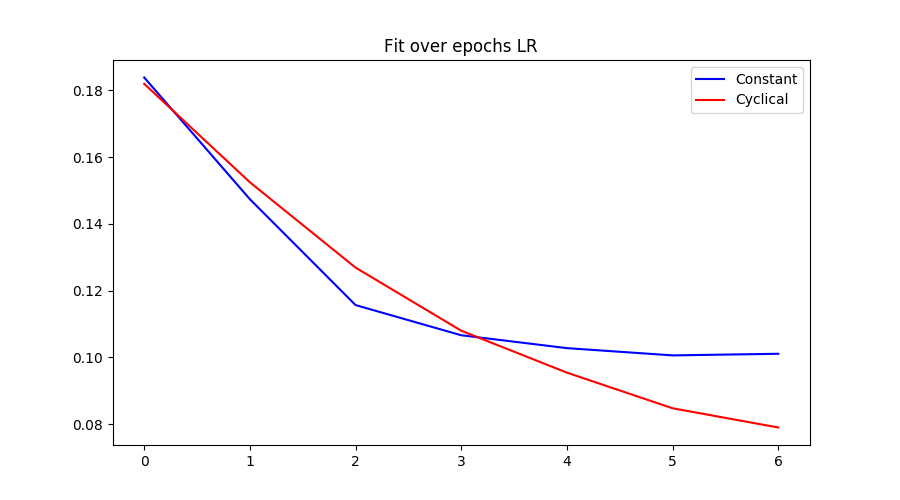

In [13]:
%matplotlib nbagg

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
ax.set_title('Fit over epochs LR')

ax.plot(np.mean(np.vstack(err_constant), axis=0)[:7], '-b', label='Constant')
ax.plot(np.mean(np.vstack(err_cyclical), axis=0)[:7], '-r', label='Cyclical')
ax.legend()